In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import json

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id

        # Fetch the dataset
        self.fetch_dataset()

        # Preprocess data
        self.preprocess_data()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        # Load data and targets
        X = self.dataset.data.features
        y = self.dataset.data.targets
    
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
    
        # Combine features and targets into a DataFrame for easy handling
        df = pd.DataFrame(data=np.column_stack((X, y)))
    
        # Drop rows with missing values
        df.dropna(inplace=True)
        df = df.apply(pd.to_numeric, errors='coerce')
    
        # Extract features and targets after handling missing values
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values


    def split_data(self):
        self.X_train, self.X_temp, self.y_train, self.y_temp = train_test_split(
            self.X, self.y, test_size=0.4, random_state=42
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            self.X_temp, self.y_temp, test_size=0.5, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_val_tensor = torch.FloatTensor(self.X_val)
        self.y_val_tensor = torch.FloatTensor(self.y_val.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.val_dataset = TensorDataset(self.X_val_tensor, self.y_val_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)

        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=32, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self, input_size, fc1_out_features=32, fc2_out_features=1, fc1_dropout=0.0, fc2_dropout=0.0, learning_rate=0.001):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, int(fc1_out_features))
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(fc1_dropout)
        self.fc2 = nn.Linear(int(fc1_out_features), int(fc2_out_features))
        self.dropout2 = nn.Dropout(fc2_dropout)
        self.fc3 = nn.Linear(int(fc2_out_features), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


class HyperparameterTuner:
    def __init__(self, model_class, param_grid, dataset):
        self.model_class = model_class
        self.param_grid = list(ParameterGrid(param_grid))
        self.dataset = dataset
        self.results = {}

    def train(self, epochs):
        for gs_idx, row in enumerate(self.param_grid):
            param_set = row

            self.results[gs_idx] = {'config': param_set, 'values': {}}

            # Create a new instance of the model with the current configuration
            model_instance = self.model_class(
                input_size=self.dataset.X_train.shape[1],
                fc1_out_features=param_set['fc1_out_features'],
                fc2_out_features=param_set['fc2_out_features'],
                fc1_dropout=param_set['fc1_dropout'],
                fc2_dropout=param_set['fc2_dropout'],
                learning_rate=param_set['learning_rate']
            )
            model_instance = model_instance.to(self.dataset.device)

            # Training loop for a fixed number of epochs
            # Training loop for a fixed number of epochs
            for epoch in range(epochs):
                model_instance.train()
                total_loss = 0
                correct_train = 0
                total_train = 0

                for inputs, labels in self.dataset.train_loader:
                    optimizer = optim.Adam(model_instance.parameters(), lr=param_set['learning_rate'])
                    optimizer.zero_grad()
                    outputs = model_instance(inputs.to(self.dataset.device))
                    criterion = nn.BCELoss()
                    loss = criterion(outputs, labels.to(self.dataset.device))
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                    # Calculate accuracy during training
                    predicted_labels = (outputs >= 0.5).float()
                    correct_train += (predicted_labels == labels.to(self.dataset.device)).sum().item()
                    total_train += labels.size(0)

                # Log training loss and accuracy
                average_train_loss = total_loss / len(self.dataset.train_loader)
                accuracy_train = correct_train / total_train

                # Evaluate the model on the test set
                model_instance.eval()
                with torch.no_grad():
                    total_val_loss = 0
                    correct_val = 0
                    total_val = 0

                    for inputs, labels in self.dataset.val_loader:
                        outputs = model_instance(inputs.to(self.dataset.device))
                        loss = criterion(outputs, labels.to(self.dataset.device))
                        total_val_loss += loss.item()

                        # Calculate accuracy during testing
                        predicted_labels = (outputs >= 0.5).float()
                        correct_val += (predicted_labels == labels.to(self.dataset.device)).sum().item()
                        total_val += labels.size(0)

                    # Log testing loss and accuracy
                    average_val_loss = total_val_loss / len(self.dataset.test_loader)
                    accuracy_val = correct_val / total_val

                # Save results for the current configuration
                result = {
                    'train_loss': average_train_loss,
                    'val_loss': average_val_loss,
                    'val_accuracy': accuracy_val,
                    'train_accuracy': accuracy_train
                }

                self.results[gs_idx]["values"][epoch + 1] = result
            model_instance.eval()
            with torch.no_grad():
                total_test_loss = 0
                correct_test = 0
                total_test = 0

                for inputs, labels in self.dataset.test_loader:
                    outputs = model_instance(inputs.to(self.dataset.device))
                    loss = criterion(outputs, labels.to(self.dataset.device))
                    total_test_loss += loss.item()

                    # Calculate accuracy during testing
                    predicted_labels = (outputs >= 0.5).float()
                    correct_test += (predicted_labels == labels.to(self.dataset.device)).sum().item()
                    total_test += labels.size(0)

                # Log testing loss and accuracy
                average_val_loss = total_test_loss / len(self.dataset.test_loader)
                accuracy_val = correct_test / total_test
                self.results[gs_idx]["test"] = {'test_loss': average_val_loss,
                                            'test_accuracy' : accuracy_val
                                           }

        # Save results to a JSON file
        json_filename = 'hyperparameter_results_UCI_BreastCancer.json'
        with open(json_filename, 'w') as json_file:
            json.dump(self.results, json_file, indent=4)

# Instantiate the TabularDataset class
dataset = TabularDataset(id=17)

# Split, standardize, and convert to tensors
dataset.split_data()
dataset.standardize_data()
dataset.convert_to_tensors()
dataset.create_dataloaders()

# Instantiate the SimpleNN class
model = SimpleNN

# Define hyperparameters to tune
param_grid = {
    'fc1_out_features': [16, 32, 64],
    'fc2_out_features': [16, 32, 64],
    'fc1_dropout': [0.0, 0.2, 0.4],
    'fc2_dropout': [0.0, 0.2, 0.4],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Instantiate the HyperparameterTuner class and train the model
tuner = HyperparameterTuner(model, param_grid, dataset)
tuner.train(epochs=50)

/home/kedar/miniconda3/envs/eeehw/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Config with least test loss: {'fc1_dropout': 0.0, 'fc1_out_features': 64, 'fc2_dropout': 0.2, 'fc2_out_features': 64, 'learning_rate': 0.001}


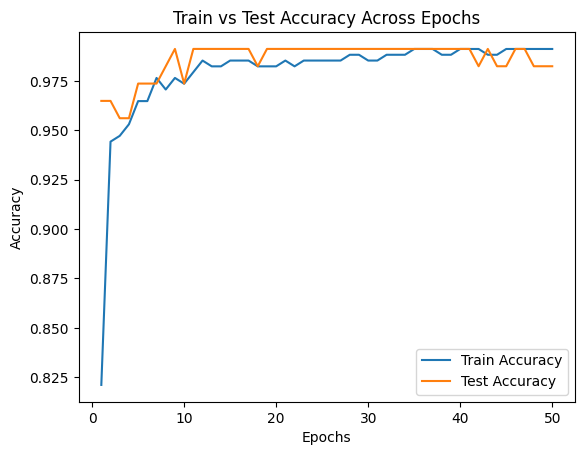

In [11]:
import json
import matplotlib.pyplot as plt

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def find_best_config(data):
    min_test_loss = float('inf')
    best_config = None

    for key, value in data.items():
        current_test_loss = value['test']['test_loss']

        if current_test_loss < min_test_loss:
            min_test_loss = current_test_loss
            best_config = value

    return best_config

def plot_accuracy_epochs(config):
    train_accuracy = [sub_value['train_accuracy'] for sub_key, sub_value in config['values'].items()]
    test_accuracy = [sub_value['val_accuracy'] for sub_key, sub_value in config['values'].items()]
    epochs = list(map(int, config['values'].keys()))

    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy Across Epochs')
    plt.legend()
    plt.show()

file_path = 'hyperparameter_results_UCI_BreastCancer.json'
json_data = read_json_file(file_path)

best_config = find_best_config(json_data)
print(f"Best Config with least test loss: {best_config['config']}")

# Plotting train vs test accuracy for the best config
plot_accuracy_epochs(best_config)


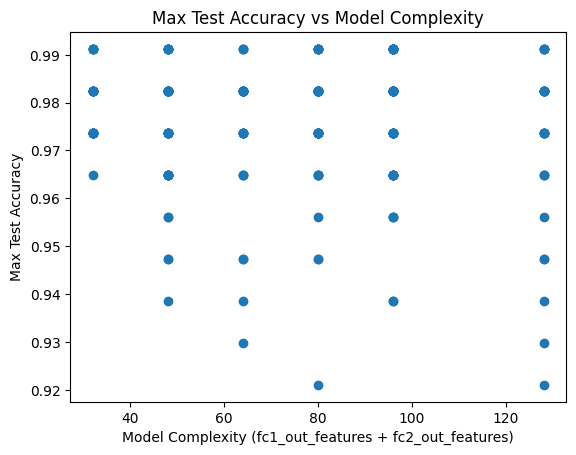

In [12]:
import json
import matplotlib.pyplot as plt

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def plot_max_accuracy_vs_complexity(data):
    complexities = []
    max_test_accuracies = []

    for key, value in data.items():
        fc1_out_features = value['config']['fc1_out_features']
        fc2_out_features = value['config']['fc2_out_features']
        complexity = fc1_out_features + fc2_out_features

        max_test_accuracy = value['test']['test_accuracy']

        complexities.append(complexity)
        max_test_accuracies.append(max_test_accuracy)

    plt.scatter(complexities, max_test_accuracies)
    plt.xlabel('Model Complexity (fc1_out_features + fc2_out_features)')
    plt.ylabel('Max Test Accuracy')
    plt.title('Max Test Accuracy vs Model Complexity')
    plt.show()

file_path = 'hyperparameter_results_UCI_BreastCancer.json'
json_data = read_json_file(file_path)

# Plotting max test accuracy vs model complexity
plot_max_accuracy_vs_complexity(json_data)
